# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic Real-Time Bidding (RTB) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the RTB environment works.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for continuous action
env = gym.make("RTBEnv-continuous-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `behavior_policy`: RL agent (or algorithm) used for the data collection.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `action_keys`: Name of the action variable at each dimension.
- `state_keys`: Name of the state variable at each dimension.
- `info_keys`: Dictionary containing of key and the type of info components.
- `random_state`: Random state.

For more about the data collection and visualization, please refer to [examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [13]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [91]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-03-18 20:26:32 [warning  ] Parameters will be reinitialized.


In [92]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [93]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [94]:
with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb).

In [95]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL, TD3PlusBC, IQL
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [96]:
# Use Conservative Q-Learning (CQL) policy
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
cql_b1.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [98]:
# save model
cql_b1.save_model("d3rlpy_logs/cql_continuous_b1.pt")

In [99]:
# reload model
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_continuous_b1.pt")

2023-03-18 20:30:33 [warning  ] Parameters will be reinitialized.


In [100]:
# Use Conservative Q-Learning (CQL) policy
# base policy 2: hidden_units = [100]
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
cql_b2.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [102]:
# save model
cql_b2.save_model("d3rlpy_logs/cql_continuous_b2.pt")

In [103]:
# reload model
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_continuous_b2.pt")

2023-03-18 20:34:02 [warning  ] Parameters will be reinitialized.


In [104]:
# Use Conservative Q-Learning (CQL) policy
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
cql_b3.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [106]:
# save model
cql_b3.save_model("d3rlpy_logs/cql_continuous_b3.pt")

In [107]:
# reload model
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_continuous_b3.pt")

2023-03-18 20:36:56 [warning  ] Parameters will be reinitialized.


In [108]:
# Use TD3 + Behavior Cloning (TD3+BC) policy
# base policy 1: hidden_units = [30, 30]
td3bc_b1 = TD3PlusBC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
td3bc_b1.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [110]:
# save model
td3bc_b1.save_model("d3rlpy_logs/td3bc_continuous_b1.pt")

In [111]:
# reload model
td3bc_b1.build_with_env(env)
td3bc_b1.load_model("d3rlpy_logs/td3bc_continuous_b1.pt")

2023-03-18 20:37:25 [warning  ] Parameters will be reinitialized.


In [112]:
# Use TD3 + Behavior Cloning (TD3+BC) policy
# base policy 2: hidden_units = [100]
td3bc_b2 = TD3PlusBC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
td3bc_b2.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [114]:
# save model
td3bc_b2.save_model("d3rlpy_logs/td3bc_continuous_b2.pt")

In [115]:
# reload model
td3bc_b2.build_with_env(env)
td3bc_b2.load_model("d3rlpy_logs/td3bc_continuous_b2.pt")

2023-03-18 20:37:52 [warning  ] Parameters will be reinitialized.


In [116]:
# Use TD3 + Behavior Cloning (TD3+BC) policy
# base policy 3: hidden_units = [50, 10]
td3bc_b3 = TD3PlusBC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
td3bc_b3.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [118]:
# save model
td3bc_b3.save_model("d3rlpy_logs/td3bc_continuous_b3.pt")

In [119]:
# reload model
td3bc_b3.build_with_env(env)
td3bc_b3.load_model("d3rlpy_logs/td3bc_continuous_b3.pt")

2023-03-18 20:38:21 [warning  ] Parameters will be reinitialized.


In [120]:
# Use Implicit Q-Learning (IQL) policy
# base policy 1: hidden_units = [30, 30]
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
iql_b1.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [122]:
# save model
iql_b1.save_model("d3rlpy_logs/iql_continuous_b1.pt")

In [123]:
# reload model
iql_b1.build_with_env(env)
iql_b1.load_model("d3rlpy_logs/iql_continuous_b1.pt")

2023-03-18 20:39:19 [warning  ] Parameters will be reinitialized.


In [124]:
# Use Implicit Q-Learning (IQL) policy
# base policy 2: hidden_units = [100]
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
iql_b2.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [126]:
# save model
iql_b2.save_model("d3rlpy_logs/iql_continuous_b2.pt")

In [127]:
# reload model
iql_b2.build_with_env(env)
iql_b2.load_model("d3rlpy_logs/iql_continuous_b2.pt")

2023-03-18 20:40:14 [warning  ] Parameters will be reinitialized.


In [128]:
# Use Implicit Q-Learning (IQL) policy
# base policy 3: hidden_units = [50, 10]
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [ ]:
iql_b3.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [130]:
# save model
iql_b3.save_model("d3rlpy_logs/iql_continuous_b3.pt")

In [131]:
# reload model
iql_b3.build_with_env(env)
iql_b3.load_model("d3rlpy_logs/iql_continuous_b3.pt")

2023-03-18 20:41:12 [warning  ] Parameters will be reinitialized.


## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [132]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [133]:
# define evaluation policies (should be a deterministic policy)
cql_b1 = ContinuousEvalHead(base_policy=cql_b1, name="cql_b1")
cql_b2 = ContinuousEvalHead(base_policy=cql_b2, name="cql_b2")
cql_b3 = ContinuousEvalHead(base_policy=cql_b3, name="cql_b3")

td3bc_b1 = ContinuousEvalHead(base_policy=td3bc_b1, name="td3bc_b1")
td3bc_b2 = ContinuousEvalHead(base_policy=td3bc_b2, name="td3bc_b2")
td3bc_b3 = ContinuousEvalHead(base_policy=td3bc_b3, name="td3bc_b3")

iql_b1 = ContinuousEvalHead(base_policy=iql_b1, name="iql_b1")
iql_b2 = ContinuousEvalHead(base_policy=iql_b2, name="iql_b2")
iql_b3 = ContinuousEvalHead(base_policy=iql_b3, name="iql_b3")

evaluation_policies = [
    cql_b1, cql_b2, cql_b3,
    td3bc_b1, td3bc_b2, td3bc_b3,
    iql_b1, iql_b2, iql_b3,
]

In [134]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        },
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [136]:
with open("logs/ope_input_dict_continuous_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [137]:
with open("logs/ope_input_dict_continuous_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [138]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [139]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict

{'cql_b1':            policy_value  relative_policy_value
 on_policy     13.620000               1.000000
 dm             2.357341               0.173079
 tis            0.389694               0.028612
 pdis          22.909113               1.682020
 dr            25.194698               1.849831
 sntis         12.050480               0.884764
 snpdis        16.320955               1.198308
 sndr          16.103669               1.182355,
 'cql_b2':            policy_value  relative_policy_value
 on_policy  1.441000e+01           1.000000e+00
 dm         3.225006e+00           2.238033e-01
 tis        2.001015e-10           1.388630e-11
 pdis       1.010542e+01           7.012781e-01
 dr         1.285395e+01           8.920158e-01
 sntis      1.463338e+00           1.015502e-01
 snpdis     2.544920e+01           1.766079e+00
 sndr       2.601626e+01           1.805431e+00,
 'cql_b3':            policy_value  relative_policy_value
 on_policy      0.100000               1.000000
 dm     

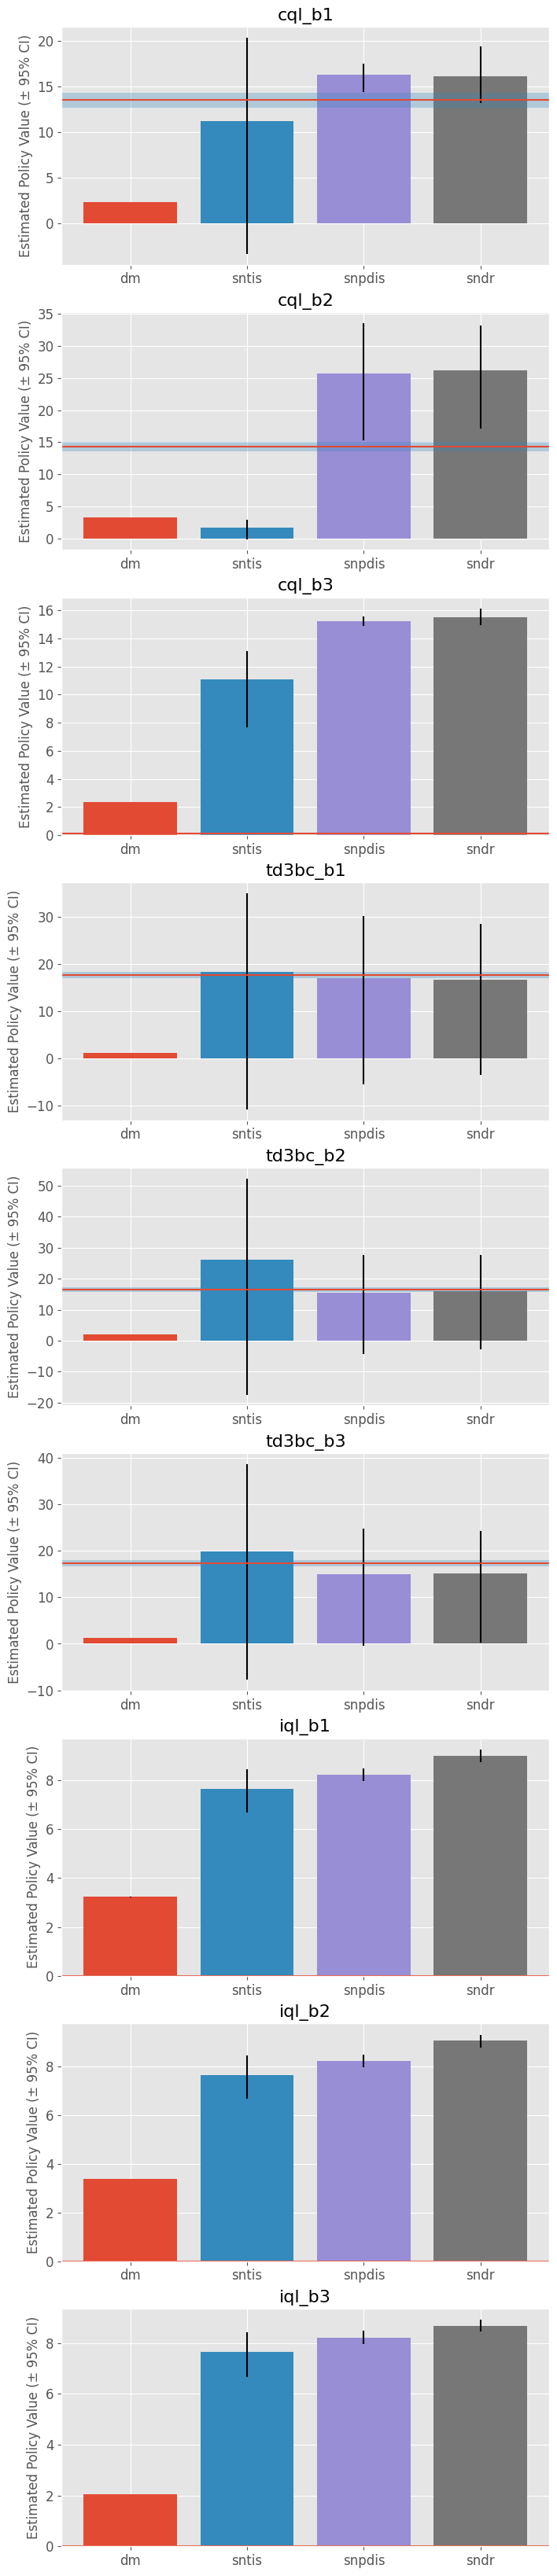

In [140]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    random_state=random_state, 
    sharey=False,
)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

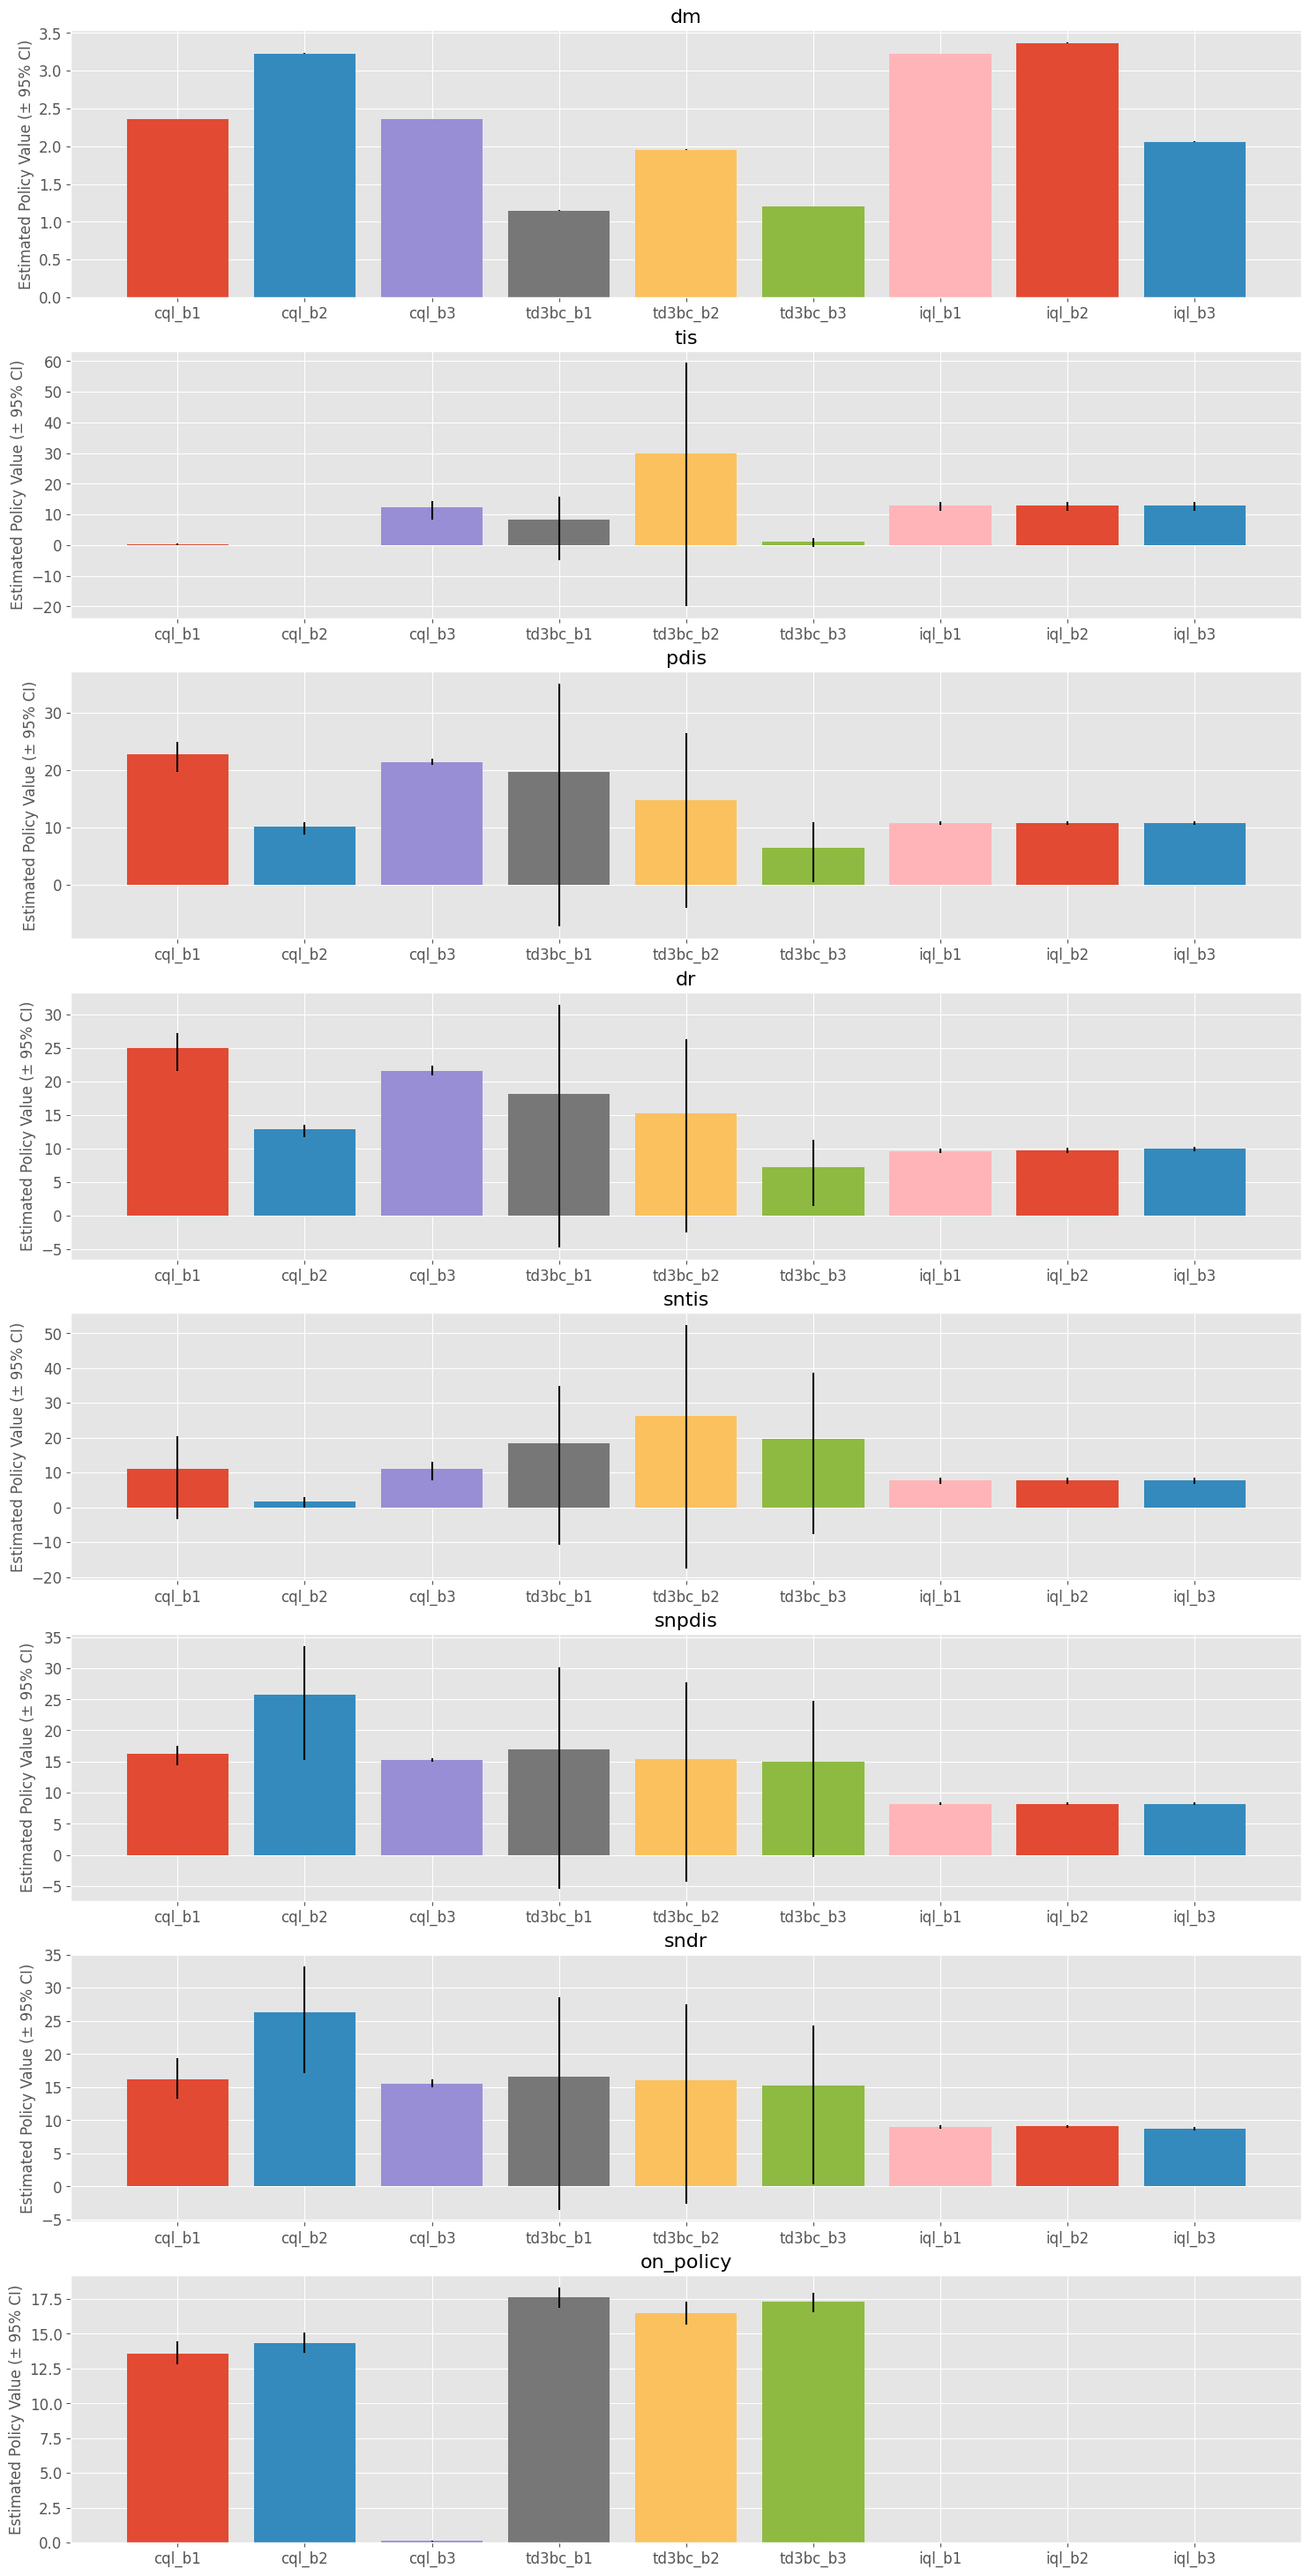

In [141]:
# we can also compare the policy value of candidate OPE estimators estimated by a single OPE estimator
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [142]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [143]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

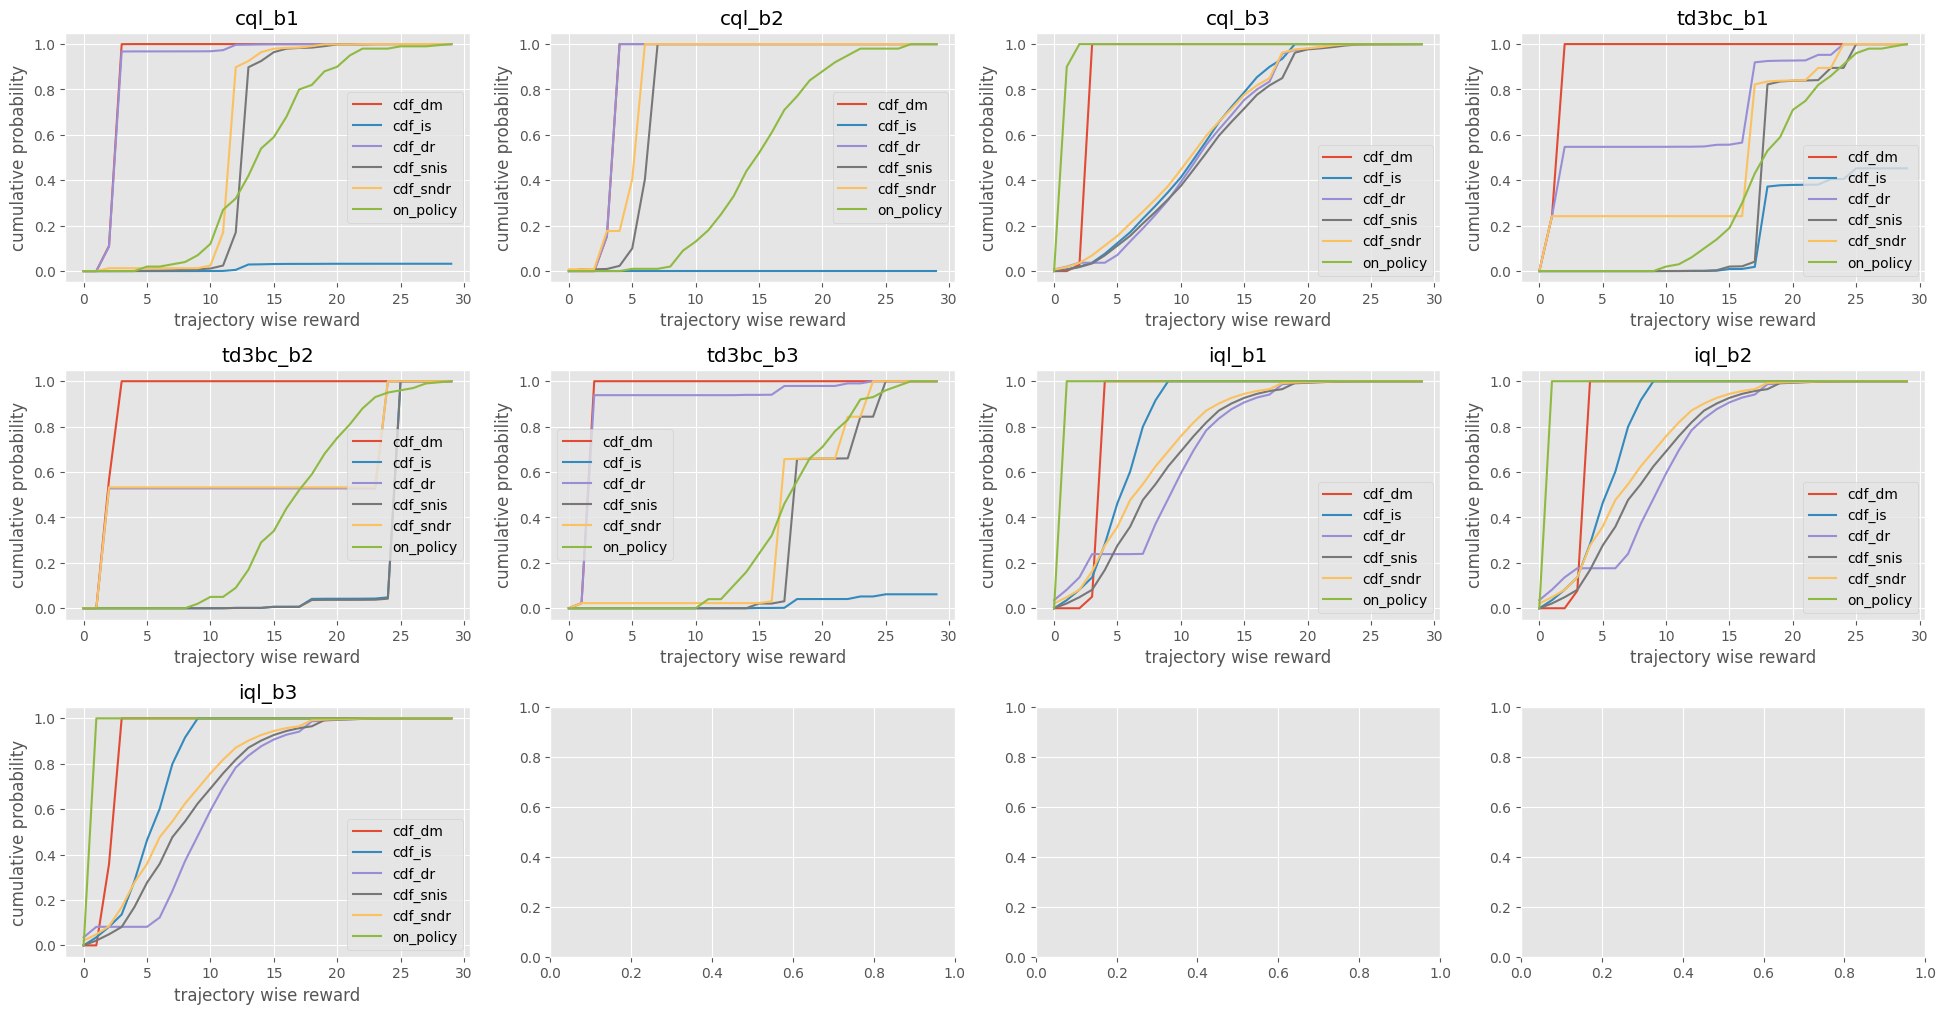

In [144]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

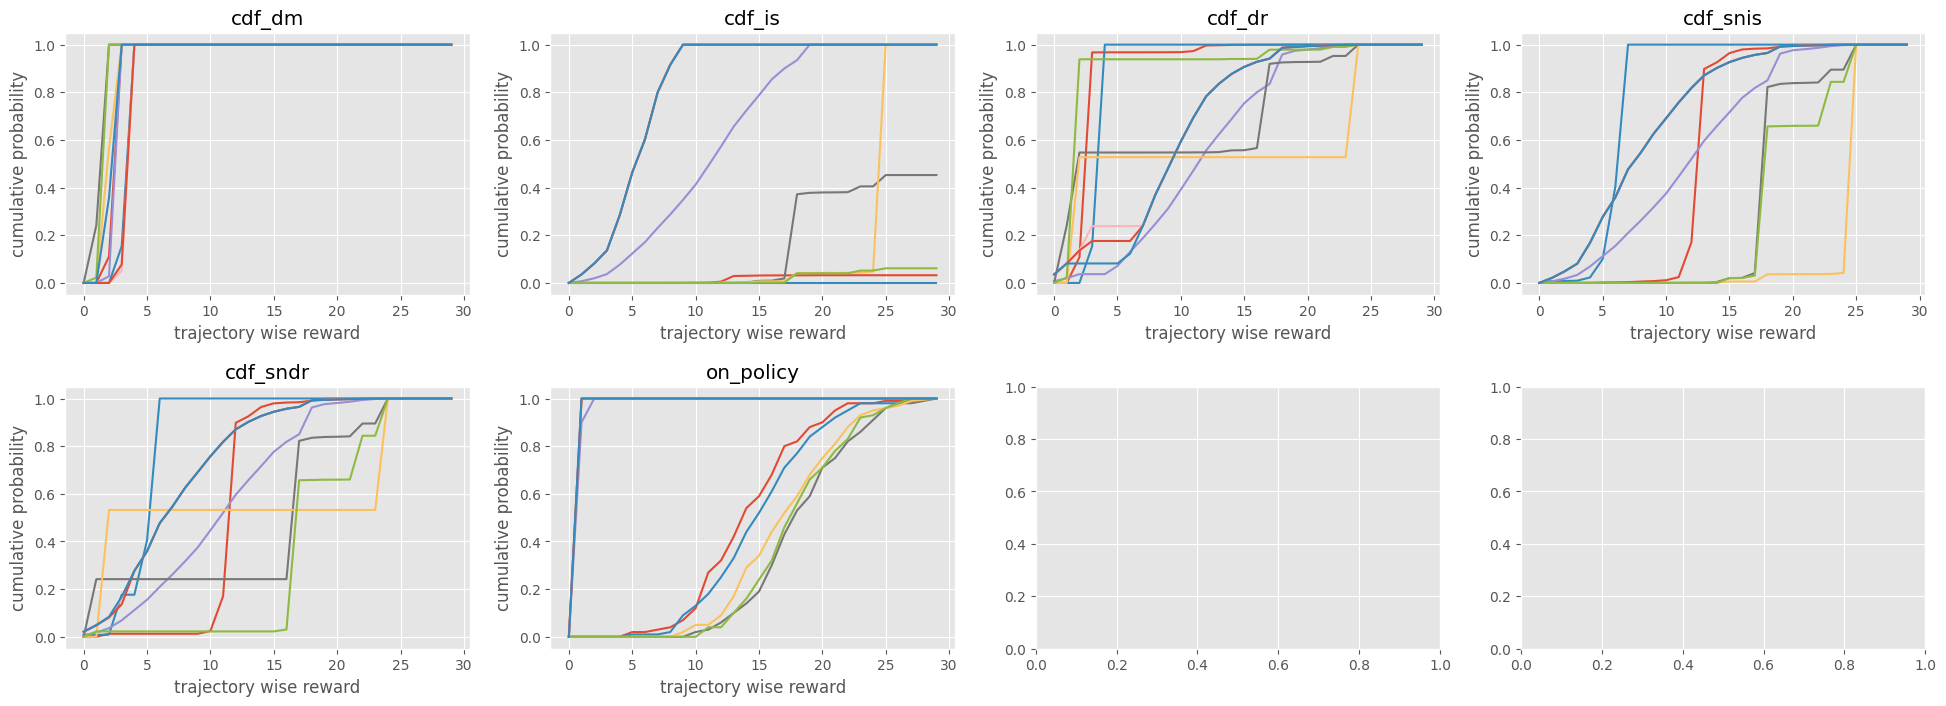

In [145]:
# cumulative distribution function comparison by each OPE estimator
# legend (evaluation policy name) is omitted here
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

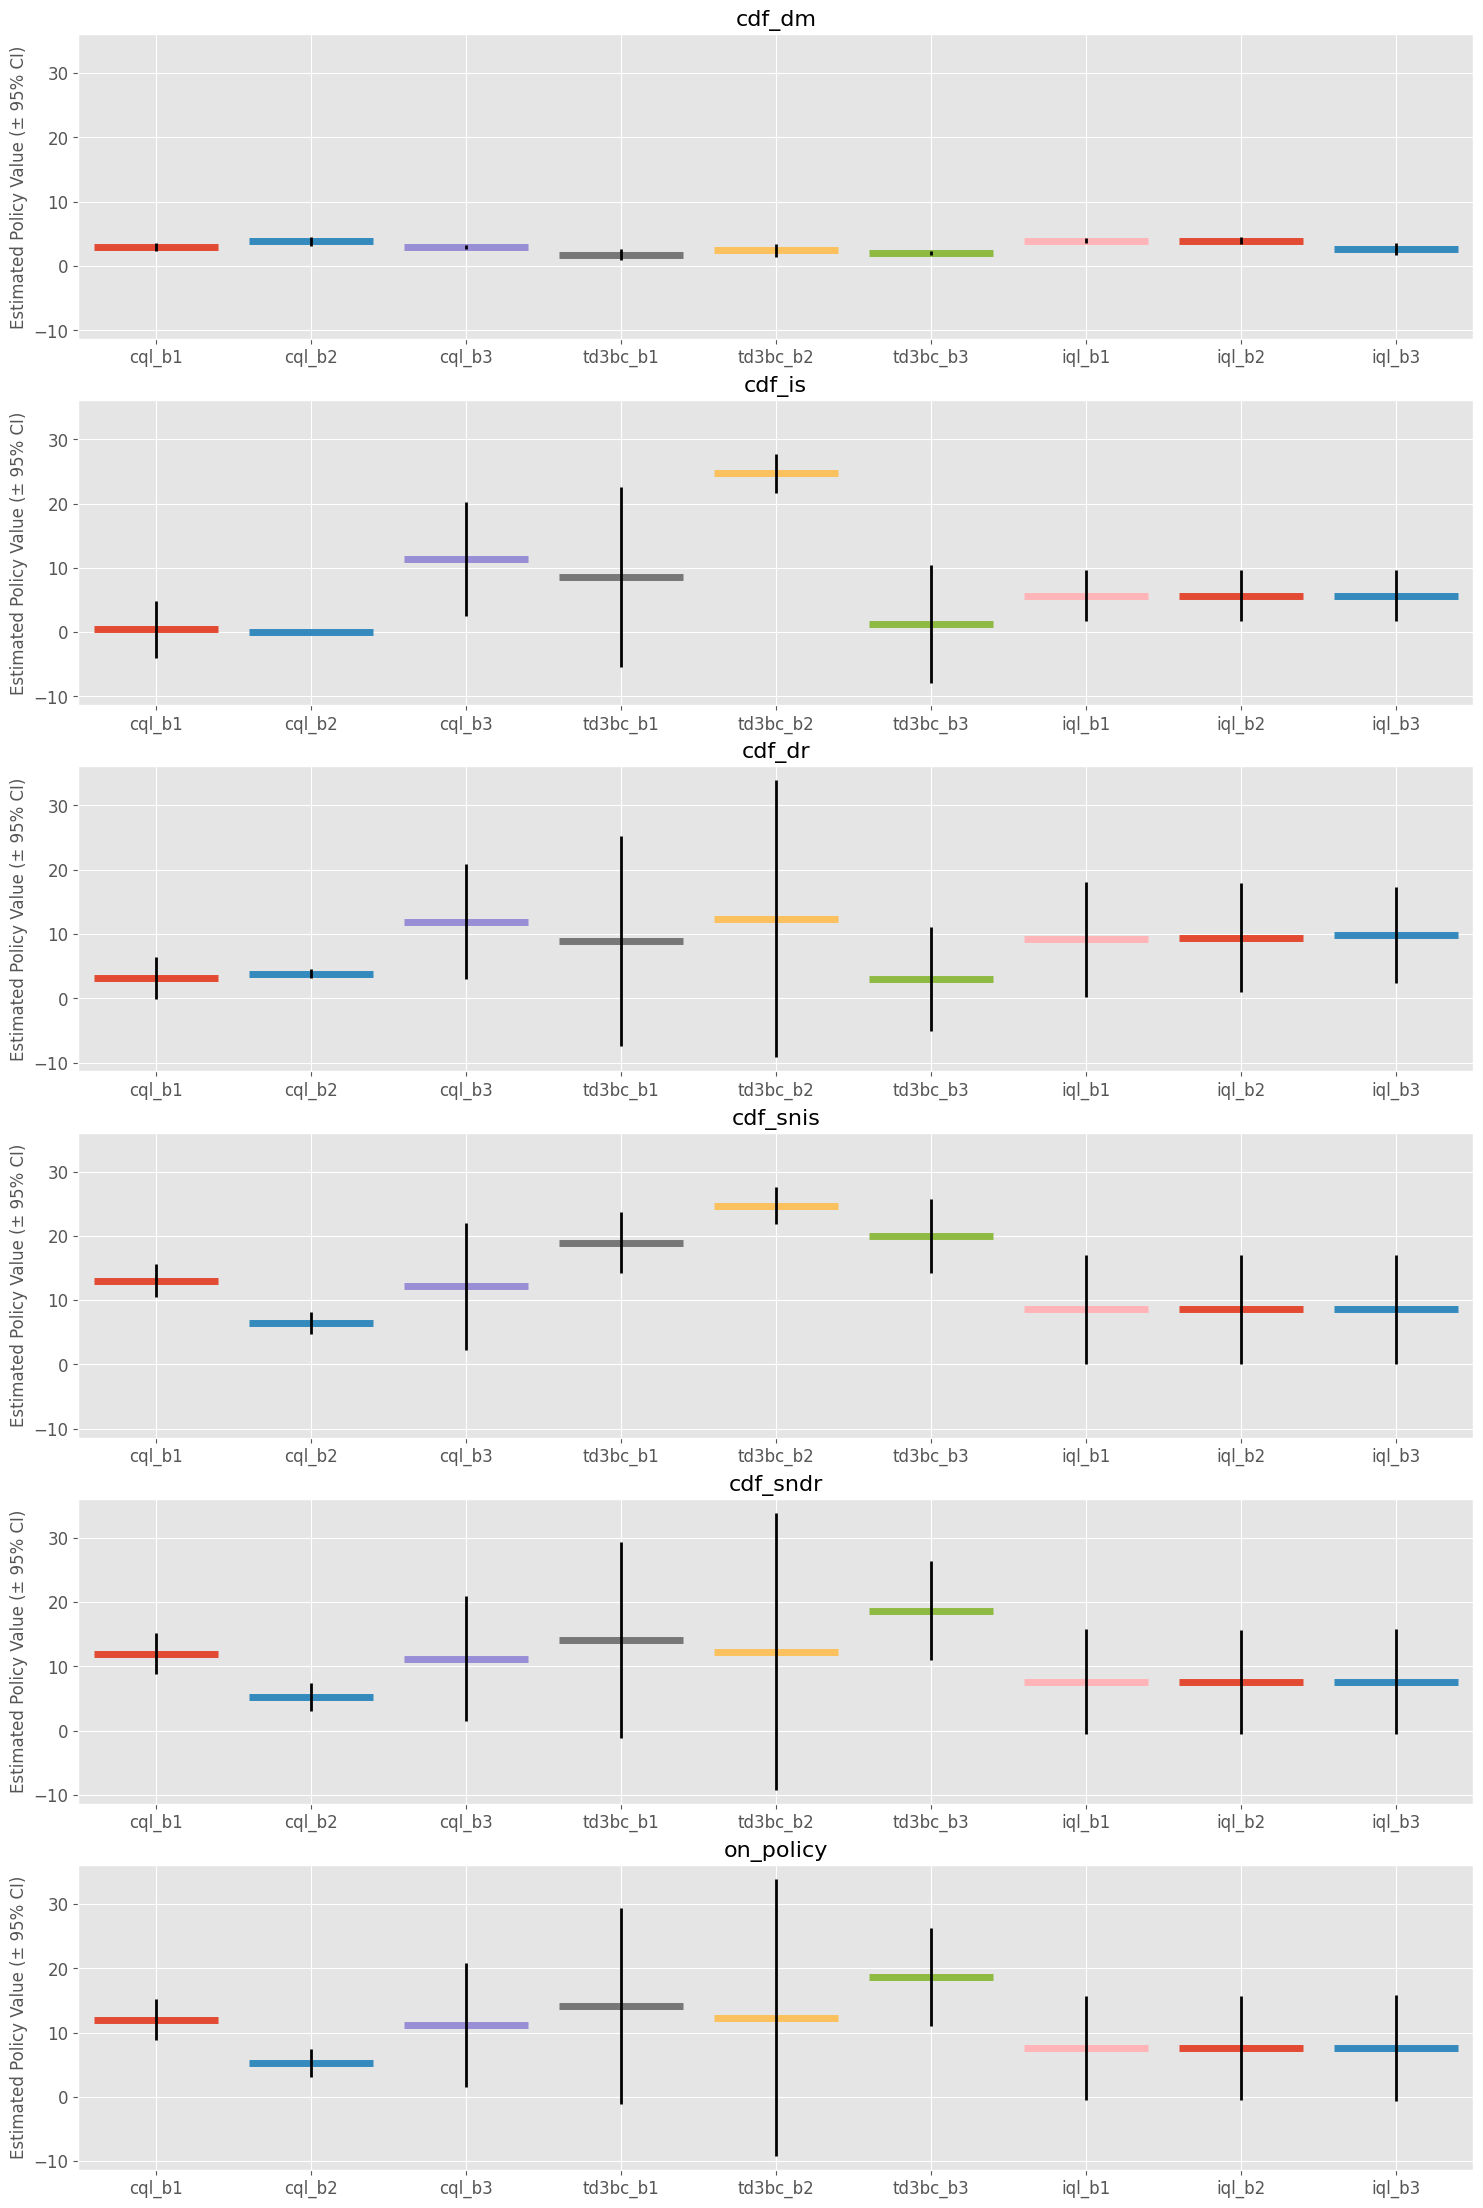

In [146]:
# policy value calculated from cumulative distribution function
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# visualize the policy value and its confidence intervals based on the mean and variance
# cd_ope.visualize_policy_value(input_dict, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

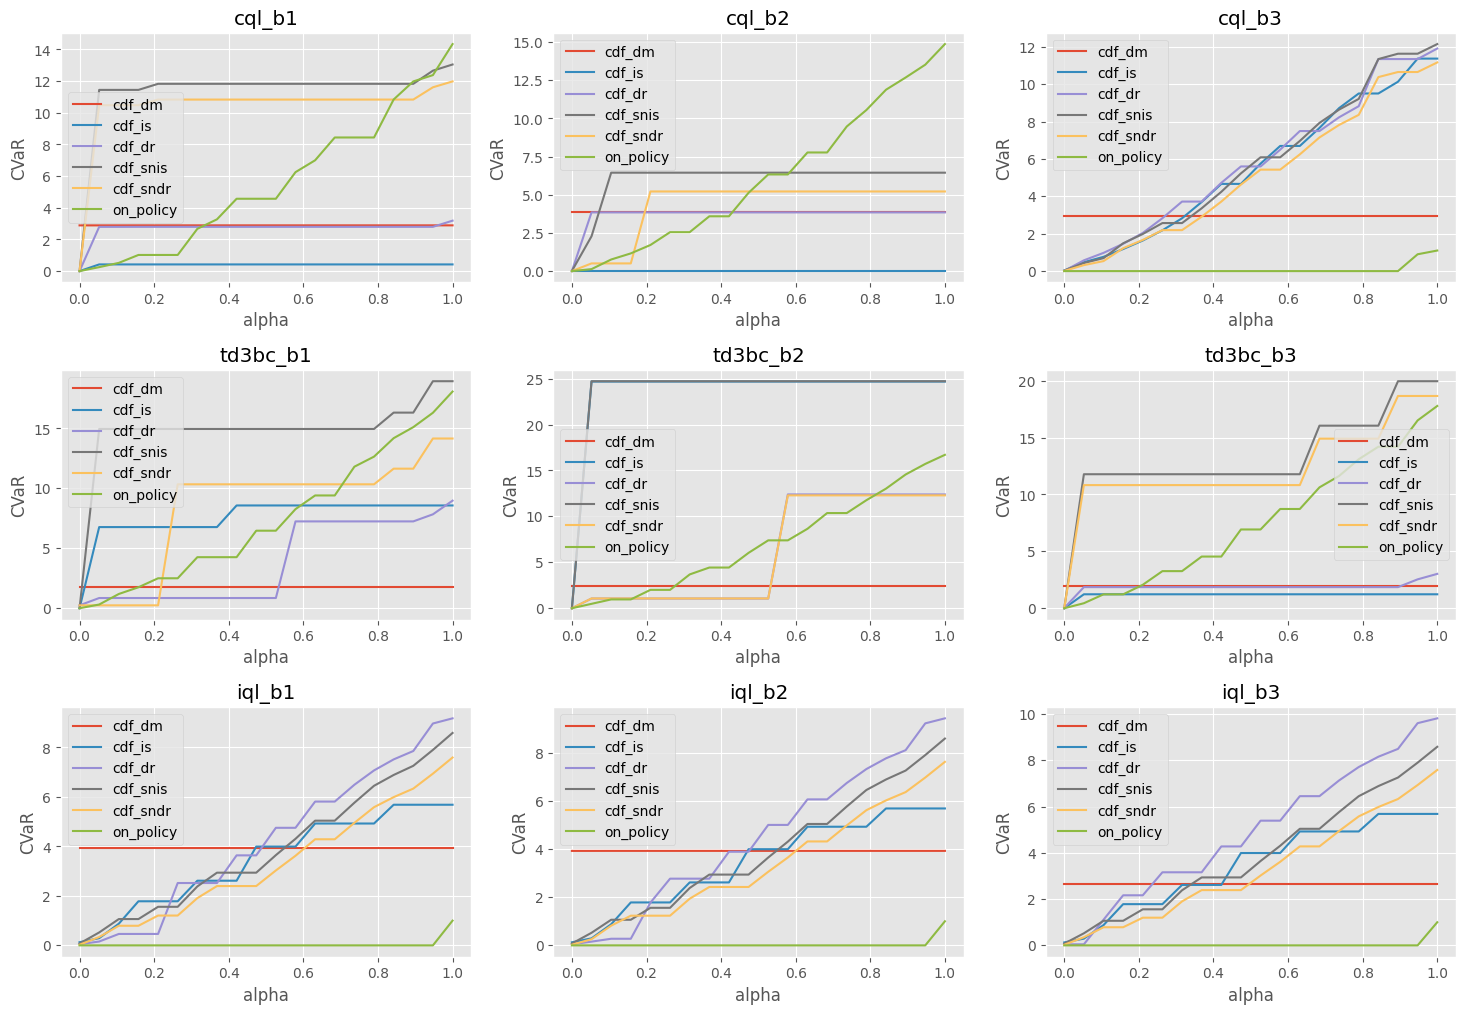

In [147]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# visualize conditional value at risk
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=3, sharey=True)
# comparison among candidate policies by an OPE estimator
# cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)

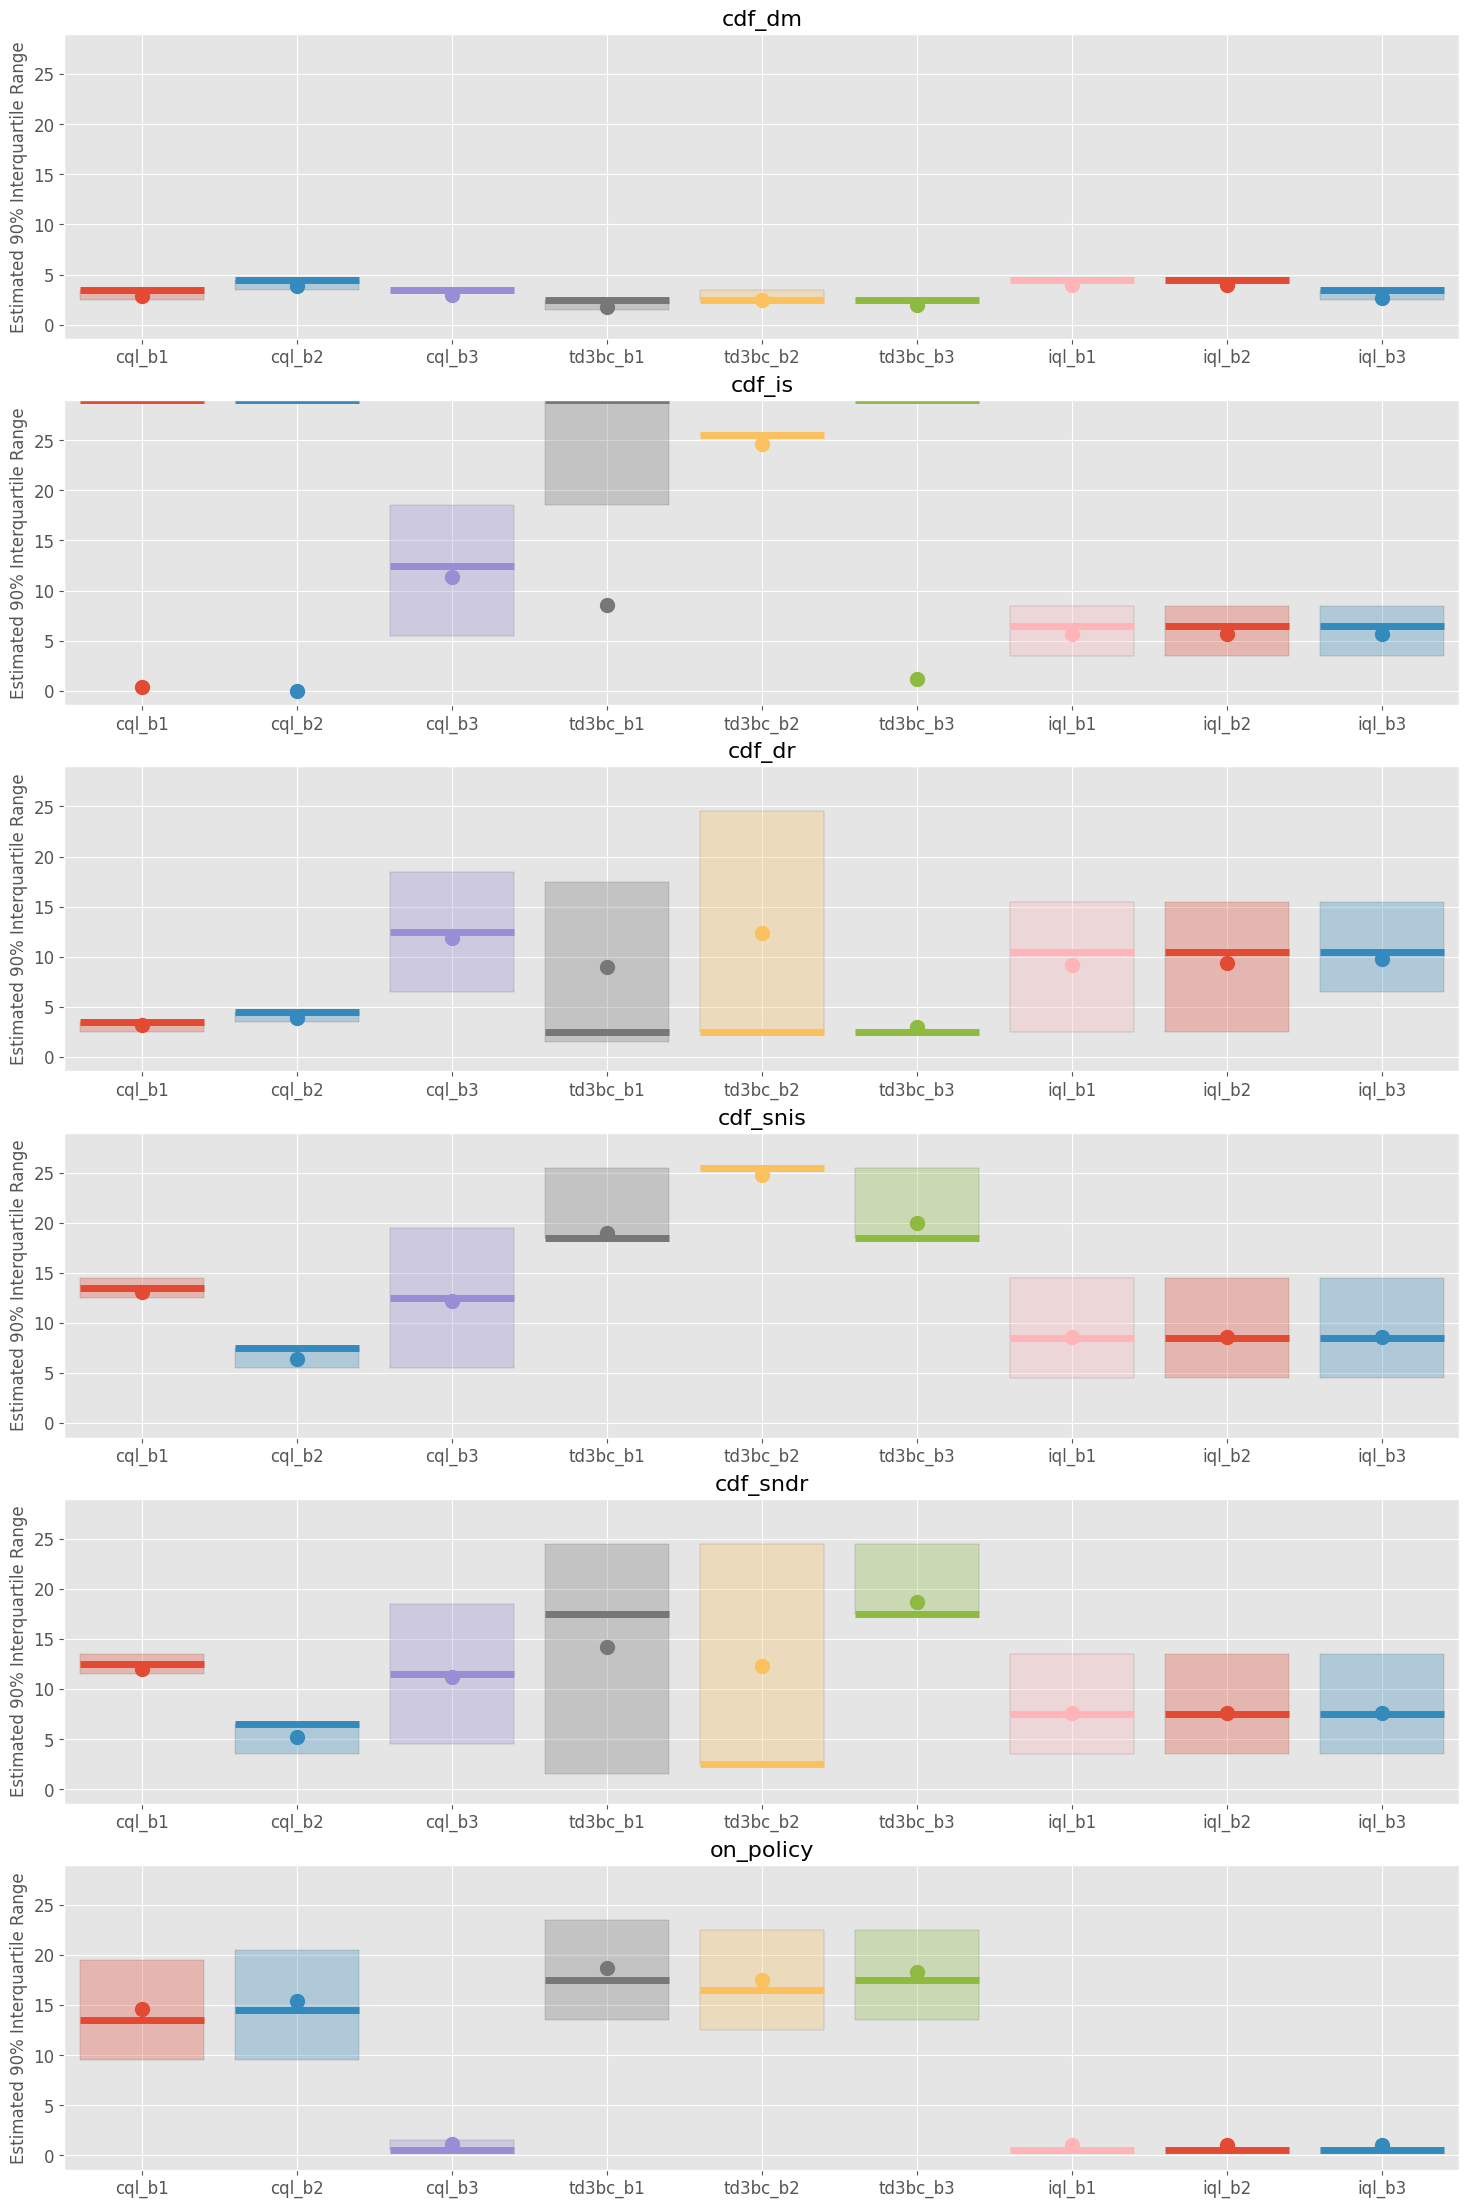

In [148]:
# interquartile range
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# visualize interquartile range
# cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [149]:
from ofrl.ope import OffPolicySelection

In [150]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [151]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

,ranking,policy_value,relative_policy_value,variance,ranking_by_lower_quartile,lower_quartile,ranking_by_conditional_value_at_risk,conditional_value_at_risk
0,td3bc_b1,17.65,1.316045,16.007576,cql_b1,12.0,td3bc_b3,10.4
1,td3bc_b3,17.31,1.290693,14.357475,cql_b2,11.0,td3bc_b1,10.0
2,td3bc_b2,16.53,1.232534,17.746566,cql_b3,10.9,td3bc_b2,8.6
3,cql_b2,14.41,1.074459,17.739293,td3bc_b1,8.0,cql_b2,7.0
4,cql_b1,13.62,1.015554,17.025859,td3bc_b2,8.0,cql_b1,5.8
5,cql_b3,0.10,0.007456,0.090909,td3bc_b3,0.0,iql_b3,0.0
6,iql_b3,0.00,0.000000,0.000000,iql_b3,0.0,iql_b2,0.0
7,iql_b2,0.00,0.000000,0.000000,iql_b2,0.0,iql_b1,0.0
8,iql_b1,0.00,0.000000,0.000000,iql_b1,0.0,cql_b3,0.0


In [152]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [153]:
ranking_df

{'dm':   estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0            iql_b2                3.364417                         0.250862   
 1            cql_b2                3.225006                         0.240467   
 2            iql_b1                3.223523                         0.240357   
 3            cql_b3                2.360451                         0.176003   
 4            cql_b1                2.357341                         0.175771   
 5            iql_b3                2.058555                         0.153493   
 6          td3bc_b2                1.952511                         0.145586   
 7          td3bc_b3                1.199667                         0.089451   
 8          td3bc_b1                1.149543                         0.085714   
 
    true_ranking  true_policy_value  true_relative_policy_value  
 0             7               0.00                    0.000000  
 1             3              14.41               

In [154]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,dm,114.146704,-0.750000,0.019942,17.65,0.0,0.0
1,tis,163.962791,-0.383333,0.308495,1.12,0.0,0.0
2,pdis,114.434342,0.033333,0.932157,4.03,0.0,0.0
3,dr,110.387164,0.250000,0.516490,4.03,0.0,0.0
4,sntis,57.720957,0.666667,0.049867,1.12,0.0,0.0
5,snpdis,63.224115,0.716667,0.029818,3.24,0.0,0.0
6,sndr,69.278732,0.716667,0.029818,3.24,0.0,0.0


In [155]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [156]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,cdf_dm,106.588469,-0.850000,0.003705,17.65,0.0,0.0
1,cdf_is,112.564426,0.016667,0.966055,1.12,0.0,0.0
2,cdf_dr,102.868230,-0.333333,0.380713,1.12,0.0,0.0
3,cdf_snis,56.227386,0.666667,0.049867,1.12,0.0,0.0
4,cdf_sndr,46.076683,0.683333,0.042442,0.34,0.0,0.0


In [157]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [158]:
metric_df

,ci,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,bootstrap,dm,NaN,-0.750000,0.019942,17.65,0.000000,0.0
1,bootstrap,tis,NaN,-0.700000,0.035770,17.65,0.000000,0.0
2,bootstrap,pdis,NaN,-0.650000,0.058073,17.55,0.000000,0.0
3,bootstrap,dr,NaN,-0.416667,0.264586,4.03,0.000000,0.0
4,bootstrap,sntis,NaN,-0.700000,0.035770,17.55,0.000000,0.0
5,bootstrap,snpdis,NaN,-0.416667,0.264586,3.24,0.000000,0.0
6,bootstrap,sndr,NaN,-0.433333,0.243952,3.24,0.000000,0.0
7,bernstein,dm,NaN,-0.833333,0.005266,17.65,0.000000,0.0
8,bernstein,tis,NaN,-0.766667,0.015944,17.65,0.666667,0.0
9,bernstein,pdis,NaN,-0.833333,0.005266,17.55,0.333333,0.0


In [159]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [160]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret,type_i_error_rate,type_ii_error_rate
0,cdf_dm,34.528889,-0.550000,0.124977,NaN,0.0,0.0
1,cdf_is,182.384444,0.766667,0.015944,NaN,0.0,0.0
2,cdf_dr,29.017778,0.450000,0.224216,NaN,0.0,0.0
3,cdf_snis,96.328889,0.433333,0.243952,NaN,0.0,0.0
4,cdf_sndr,56.528889,0.300000,0.432845,NaN,0.0,0.0


In [161]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [162]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret,type_i_error_rate,type_ii_error_rate
0,cdf_dm,26.901344,-0.783333,0.012520,NaN,0.0,0.0
1,cdf_is,48.432966,0.450000,0.224216,NaN,0.0,0.0
2,cdf_dr,25.886659,0.566667,0.111633,NaN,0.0,0.0
3,cdf_snis,37.920754,0.866667,0.002495,NaN,0.0,0.0
4,cdf_sndr,24.073854,0.433333,0.243952,NaN,0.0,0.0


In [163]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [164]:
topk_metric_df[:30]

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,0.00,0.00,0.00,0.000000,NaN,1.0,NaN
1,dm,1,14.41,14.41,0.00,7.205000,10.189409,1.0,0.098004
2,dm,2,0.00,14.41,0.00,4.803333,8.319617,1.0,0.120030
3,dm,3,0.10,14.41,0.00,3.627500,7.188488,1.0,0.138917
4,dm,4,13.62,14.41,0.00,5.626000,7.663275,1.0,0.130310
5,dm,5,0.00,14.41,0.00,4.688333,7.228827,1.0,0.138141
6,dm,6,16.53,16.53,0.00,6.380000,7.973629,1.0,0.391114
7,dm,7,17.31,17.31,0.00,7.746250,8.332419,1.0,0.467883
8,dm,8,17.65,17.65,0.00,8.846667,8.464561,1.0,0.500747
0,tis,0,16.53,16.53,16.53,16.530000,NaN,1.0,NaN


In [166]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [167]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,0.00,0.00,0.0,0.000000,NaN,1.0,NaN
1,cdf_dm,1,0.00,0.00,0.0,0.000000,0.000000,1.0,-inf
2,cdf_dm,2,14.41,14.41,0.0,4.803333,8.319617,1.0,0.120030
3,cdf_dm,3,0.10,14.41,0.0,3.627500,7.188488,1.0,0.138917
4,cdf_dm,4,13.62,14.41,0.0,5.626000,7.663275,1.0,0.130310


In [168]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [169]:
topk_metric_df.head()

,ci,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,bootstrap,dm,0,0.00,0.00,0.0,0.000,NaN,1.0,NaN
1,bootstrap,dm,1,17.31,17.31,0.0,8.655,12.240018,1.0,0.318513
2,bootstrap,dm,2,0.00,17.31,0.0,5.770,9.993933,1.0,0.390097
3,bootstrap,dm,3,16.53,17.31,0.0,8.460,9.773955,1.0,0.398876
4,bootstrap,dm,4,17.65,17.65,0.0,10.298,9.409510,1.0,0.450459


In [170]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [171]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,0.0,0.0,0.0,0.000000,NaN,1.0,NaN
1,dm,1,7.6,7.6,0.0,3.800000,5.374012,1.0,-1.081390
2,dm,2,0.0,7.6,0.0,2.533333,4.387862,1.0,-1.324426
3,dm,3,0.0,7.6,0.0,1.900000,3.800000,1.0,-1.529316
4,dm,4,7.2,7.6,0.0,2.960000,4.055613,1.0,-1.432928


In [172]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [173]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,0.0,0.0,0.0,0.000000,NaN,1.0,NaN
1,cdf_dm,1,0.0,0.0,0.0,0.000000,0.000000,1.0,-inf
2,cdf_dm,2,7.6,7.6,0.0,2.533333,4.387862,1.0,-1.324426
3,cdf_dm,3,0.0,7.6,0.0,1.900000,3.800000,1.0,-1.529316
4,cdf_dm,4,7.2,7.6,0.0,2.960000,4.055613,1.0,-1.432928


In [174]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [175]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,0.0,0.0,0.0,0.000,NaN,1.0,NaN
1,dm,1,12.9,12.9,0.0,6.450,9.121677,1.0,-0.056064
2,dm,2,0.0,12.9,0.0,4.300,7.447818,1.0,-0.068664
3,dm,3,12.0,12.9,0.0,6.225,7.197395,1.0,-0.071053
4,dm,4,12.9,12.9,0.0,7.560,6.911078,1.0,-0.073997


In [176]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [177]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,0.0,0.0,0.0,0.000,NaN,1.0,NaN
1,cdf_dm,1,0.0,0.0,0.0,0.000,0.000000,1.0,-inf
2,cdf_dm,2,12.0,12.0,0.0,4.000,6.928203,1.0,-0.203718
3,cdf_dm,3,12.9,12.9,0.0,6.225,7.197395,1.0,-0.071053
4,cdf_dm,4,0.0,12.9,0.0,4.980,6.826566,1.0,-0.074913


In [178]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    safety_criteria=1.0,
    legend=True,
)

{'ranking': ['td3bc_b1', 'td3bc_b3', 'td3bc_b2', 'cql_b2', 'cql_b1', 'cql_b3', 'iql_b3', 'iql_b2', 'iql_b1'], 'policy_value': array([17.65, 17.31, 16.53, 14.41, 13.62,  0.1 ,  0.  ,  0.  ,  0.  ]), 'relative_policy_value': array([1.31604456, 1.29069299, 1.23253352, 1.07445904, 1.01555393,
       0.00745634, 0.        , 0.        , 0.        ]), 'variance': None, 'ranking_by_lower_quartile': None, 'lower_quartile': None, 'ranking_by_conditional_value_at_risk': None, 'conditional_value_at_risk': None, 'parameters': {'quartile_alpha': None, 'cvar_alpha': None}}


AttributeError: 'dict' object has no attribute 'min'

In [ ]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    safety_criteria=1.0,
    legend=True,
)

In [ ]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    safety_criteria=1.0,
    legend=True,
    random_state=12345,
)

In [179]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
)

{'ranking': ['td3bc_b1', 'td3bc_b3', 'td3bc_b2', 'cql_b2', 'cql_b1', 'cql_b3', 'iql_b3', 'iql_b2', 'iql_b1'], 'policy_value': array([17.65, 17.31, 16.53, 14.41, 13.62,  0.1 ,  0.  ,  0.  ,  0.  ]), 'relative_policy_value': array([1.31604456, 1.29069299, 1.23253352, 1.07445904, 1.01555393,
       0.00745634, 0.        , 0.        , 0.        ]), 'variance': None, 'ranking_by_lower_quartile': None, 'lower_quartile': None, 'ranking_by_conditional_value_at_risk': ['td3bc_b3', 'td3bc_b1', 'td3bc_b2', 'cql_b2', 'cql_b1', 'iql_b3', 'iql_b2', 'iql_b1', 'cql_b3'], 'conditional_value_at_risk': array([11.2, 10.9,  9.9,  7.6,  7.2,  0. ,  0. ,  0. ,  0. ]), 'parameters': {'quartile_alpha': None, 'cvar_alpha': 0.1}}


AttributeError: 'dict' object has no attribute 'min'

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=10.0,
    legend=True,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=10.0,
    legend=True,
)

In [ ]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

In [ ]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_policy_value_lower_bound_for_validation(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    alpha=0.30,
    share_axes=True,
    random_state=12345,
)

In [ ]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

To see how to conduct OPE/OPS with multiple datasets, please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rtb/rtb_synthetic_continuous_multiple_datasets.ipynb).

For the examples in the discrete action space, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/rtb/rtb_synthetic_discrete_advanced.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Ilya Kostrikov, Ashvin Nair, and Sergey Levine. \
"Offline Reinforcement Learning with Implicit Q-Learning.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Scott Fujimoto and Shixiang Shane Gu. \
"A Minimalist Approach to Offline Reinforcement Learning.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.